In [1]:
import logging
from calendar import month

from numpy.ma.core import product

logging.basicConfig(level=logging.INFO)

logger = logging.getLogger(__name__)

# Acorn Dataset
import importlib
import custom_datasets.aus_acorn_sat_data
importlib.reload(custom_datasets.aus_acorn_sat_data)

import torch
from torch.utils.data import DataLoader

print(f"Torch version {torch.__version__}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"CUDA Available: {torch.cuda.is_available()}")

from config import ROOT_DIR
import os
model_path = os.path.join(ROOT_DIR, '.models', 'acorn_ffnn.pth')

dataset_train = custom_datasets.aus_acorn_sat_data.AusAcornSatData(mode="max")
dataset_test = custom_datasets.aus_acorn_sat_data.AusAcornSatData(mode="max", train=False)

print (dataset_train.min_values)
print (dataset_train.max_values)

original_dataset = dataset_train

train_loader = DataLoader(dataset_train, batch_size=1024, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=1024, shuffle=False)

print(f"Dataset size: {len(dataset_train)}")
print(f"Batch size: {train_loader.batch_size}")
print(f"Number of batches: {len(train_loader)}")

# Shape verification
batch_x, batch_y = next(iter(train_loader))
logger.info(f"Batch shapes: x={batch_x.shape}, y={batch_y.shape}")
logger.info(f"Batch dtypes: x={batch_x.dtype}, y={batch_y.dtype}")


Torch version 2.7.1+cu118
CUDA Available: True


INFO:__main__:Batch shapes: x=torch.Size([1024, 5]), y=torch.Size([1024, 1])
INFO:__main__:Batch dtypes: x=torch.float32, y=torch.float32


{'max': np.float64(-3.3), 'lat': np.float64(-43.49), 'lon': np.float64(113.67), 'elevation': np.int64(2), 'days_since_start': np.int64(0), 'days_since_start_of_year': np.int32(1)}
{'max': np.float64(49.6), 'lat': np.float64(-10.58), 'lon': np.float64(153.47), 'elevation': np.int64(1482), 'days_since_start': np.int64(42003), 'days_since_start_of_year': np.int32(366)}
Dataset size: 319620
Batch size: 1024
Number of batches: 313


In [3]:
import torch.nn as nn

class FFNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(5, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.net(x)

In [26]:
import torch.optim as optim
num_epochs = 10

model = FFNN().to(device)

optimizer = optim.Adam(model.parameters())
criterion = nn.MSELoss()

best_loss = float('inf')

logger.info("Starting Training...")
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for x, y in train_loader:
        batch_x = x.to(device)
        batch_y = y.to(device)
        optimizer.zero_grad()

        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        total_loss = 0
        for x, y in test_loader:
            batch_x = x.to(device)
            batch_y = y.to(device)
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            total_loss += loss.item()
        avg_loss = total_loss / len(test_loader)
        logger.info(f"Epoch {epoch+1}/{num_epochs}, Test Loss: {avg_loss:.8f}")

        logger.info(f"Best Loss: {best_loss:.8f}, Current Loss: {avg_loss:.8f}")
        if avg_loss < best_loss:
            best_loss = avg_loss
            torch.save(model.state_dict(), model_path)
        else:
            logger.info("Loss did not improve, stopping training.")
            break

model.eval()

INFO:__main__:Starting Training...
INFO:__main__:Epoch 1/10, Test Loss: 0.0046
INFO:__main__:Best Loss: inf, Current Loss: 0.0046
INFO:__main__:Epoch 2/10, Test Loss: 0.0045
INFO:__main__:Best Loss: 0.0046, Current Loss: 0.0045
INFO:__main__:Epoch 3/10, Test Loss: 0.0045
INFO:__main__:Best Loss: 0.0045, Current Loss: 0.0045
INFO:__main__:Epoch 4/10, Test Loss: 0.0044
INFO:__main__:Best Loss: 0.0045, Current Loss: 0.0044
INFO:__main__:Epoch 5/10, Test Loss: 0.0044
INFO:__main__:Best Loss: 0.0044, Current Loss: 0.0044
INFO:__main__:Epoch 6/10, Test Loss: 0.0044
INFO:__main__:Best Loss: 0.0044, Current Loss: 0.0044
INFO:__main__:Epoch 7/10, Test Loss: 0.0044
INFO:__main__:Best Loss: 0.0044, Current Loss: 0.0044
INFO:__main__:Loss did not improve, stopping training.


FFNN(
  (net): Sequential(
    (0): Linear(in_features=5, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [56]:
from datetime import date, timedelta

model = FFNN().to(device)
model.load_state_dict(torch.load(model_path, weights_only=True))

        #'lat': -33.9607047,
        #'lon': 151.128669,

def predict(lat, lon, elevation, prediction_date):
    days_between = (prediction_date - dataset_start).days
    test_data =  {
        'lat': lat,
        'lon': lon,
        'elevation': elevation,
        'days_since_start': days_between,
        'days_since_start_of_year': (prediction_date - date(prediction_date.year, 1, 1)).days
    }

    test_tensor = original_dataset.normalize(test_data).to(device)

    with torch.no_grad():
        output = model(test_tensor)
    value = output.cpu().item()
    predicted_temperature = original_dataset.denormalize(value)
    return predicted_temperature

dataset_start = date(1910, 1, 1)
start = date.today()
for i in range(12):
    target_date = start + timedelta(days=i*30)
    p = predict(-33.9607047, 151.128669, 29, target_date)
    print(f"PMax {prediction_date}: {p:.2f}°C")

PMax 2027-01-11: 27.22°C
PMax 2027-01-11: 26.41°C
PMax 2027-01-11: 24.34°C
PMax 2027-01-11: 20.43°C
PMax 2027-01-11: 18.26°C
PMax 2027-01-11: 17.55°C
PMax 2027-01-11: 19.04°C
PMax 2027-01-11: 22.00°C
PMax 2027-01-11: 23.72°C
PMax 2027-01-11: 24.93°C
PMax 2027-01-11: 26.25°C
PMax 2027-01-11: 28.18°C


C:\Users\Jamie\AppData\Local\Temp\ipykernel_17656\3694832310.py:15: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  australia = australia[australia.geometry.centroid.y < -10.5]


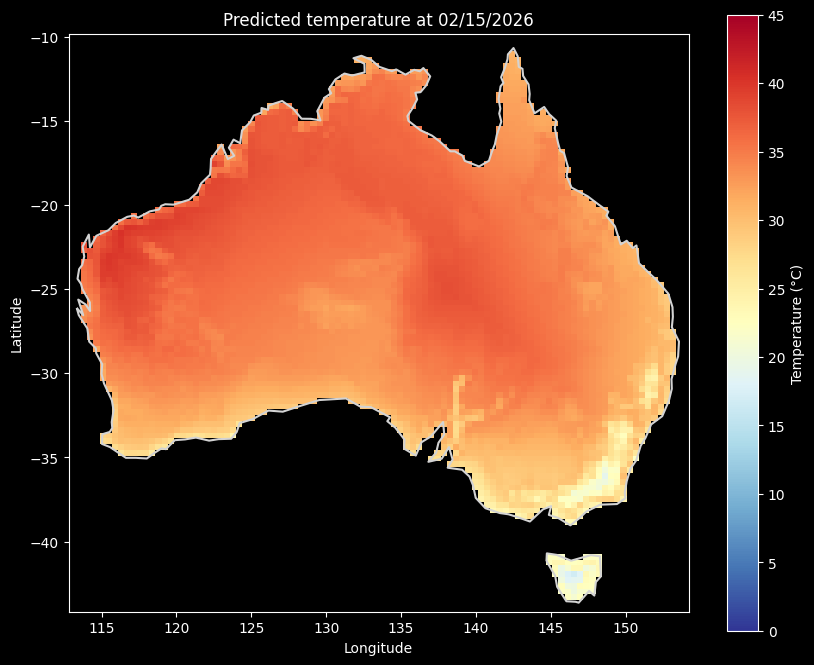

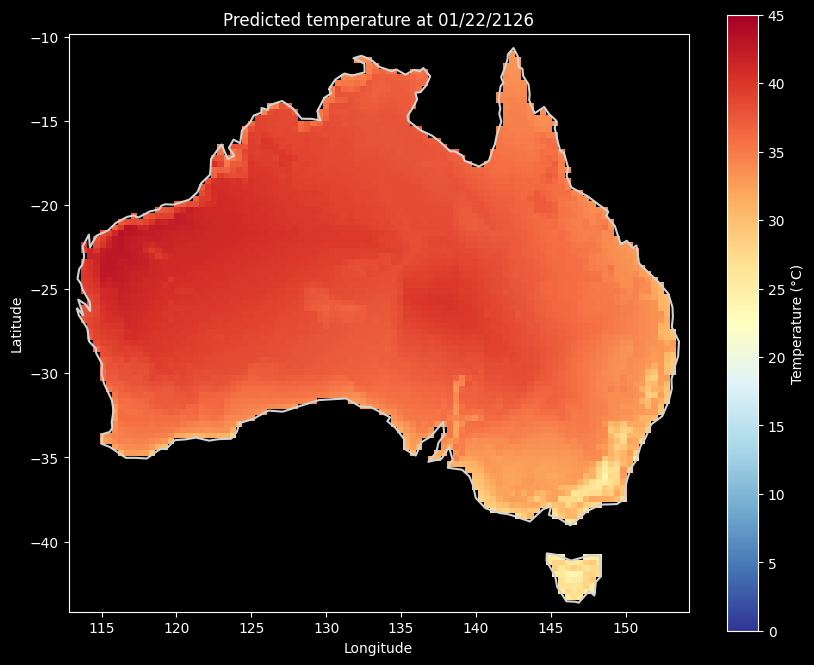

In [96]:
import geopandas as gpd
import geodatasets
import numpy as np
import pandas as pd
from shapely.geometry import Point
from matplotlib import pyplot as plt
import rasterio
import os

australia = gpd.read_file(geodatasets.get_path("naturalearth.land"))
australia = australia.cx[113:154, -44:-10]

# Bit of a hack to make it Australia only
# Irritatingly hard to get a low res country-labeled dataset
australia = australia[australia.geometry.centroid.y < -10.5]
australia_geom = australia_geom = australia.geometry.union_all()

lons = np.linspace(113, 154, 100)
lats = np.linspace(-44, -10, 100)
LON, LAT = np.meshgrid(lons, lats)

points = [Point(x, y) for x, y in zip(LON.ravel(), LAT.ravel())]
mask = np.array([australia_geom.contains(pt) for pt in points])

with rasterio.open(os.path.join(ROOT_DIR, 'linear_acorn_sat_climate', 'ETOPO1_lowres.tif')) as dataset:
    elevation_data = np.array([
        dataset.read(1)[row, col]
        for x, y in zip(LON.ravel(), LAT.ravel())
        for row, col in [dataset.index(x, y)]
    ])

    def display(prediction_date):
        days_since_start = (prediction_date - dataset_start).days
        days_since_start_of_year = (prediction_date - date(prediction_date.year, 1, 1)).days

        df = pd.DataFrame({
            'lat': LAT.ravel(),
            'lon': LON.ravel(),
            'elevation': elevation_data,
            'days_since_start': days_since_start,
            'days_since_start_of_year': days_since_start_of_year
        })


        for key in df.columns:
            min_v = original_dataset.min_values[key]
            max_v = original_dataset.max_values[key]
            df[key] = (df[key] - min_v) / (max_v - min_v)
        input_tensor = torch.tensor(df.values, dtype=torch.float32).to(device)

        with torch.no_grad():
            outputs = model(input_tensor)
        predicted_temperatures = [original_dataset.denormalize(v.item()) for v in outputs]

        predicted_temperatures = np.where(mask, predicted_temperatures, np.nan)
        predicted_temperatures = predicted_temperatures.reshape(LON.shape)
        fig, ax = plt.subplots(figsize=(10, 8))
        mesh = ax.pcolormesh(LON, LAT, predicted_temperatures, cmap='RdYlBu_r', shading='auto', vmin=0, vmax=45)
        australia.boundary.plot(ax=ax, color='lightgray', edgecolor='black')
        plt.colorbar(mesh, label='Temperature (°C)')
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.set_title(f"Predicted temperature at {prediction_date.strftime('%m/%d/%Y')}")


        plt.show()

display(date.today())
display(date.today() + timedelta(days=365*100))